In [107]:
import numpy as np
import librosa
from scipy.io import wavfile
from glob import glob
import re

In [108]:
class DataGenerator(object):
    def __init__(self, input_dir):

        self._input_files = None

        self.input_dir = input_dir
        self.sample_rate = 16000
        self.duration = 1.  # sec
        self.n_fft = 512
        self.n_mels = 64
        self.msg_w = 256

        # random mixing settings

        self.mix_with = {}

        self.mix_with[self.input_dir +
                      '/_background_noise_/doing_the_dishes.wav'] = {
                          'volume': [1., 0.25],
                          'probability': 0.1
                      }

        self.mix_with[self.input_dir +
                      '/_background_noise_/exercise_bike.wav'] = {
                          'volume': [1., 0.25],
                          'probability': 0.1
                      }

        self.mix_with[self.input_dir +
                      '/_background_noise_/white_noise.wav'] = {
                          'volume': [0.3, 0.05],
                          'probability': 0.1
                      }

        self.mix_with[self.input_dir +
                      '/_background_noise_/dude_miaowing.wav'] = {
                          'volume': [1., 0.25],
                          'probability': 0.1
                      }

        self.mix_with[self.input_dir +
                      '/_background_noise_/pink_noise.wav'] = {
                          'volume': [0.3, 0.05],
                          'probability': 0.1
                      }

        self.mix_with[self.input_dir +
                      '/_background_noise_/running_tap.wav'] = {
                          'volume': [1., 0.25],
                          'probability': 0.1
                      }

        # random transforms

        self.transforms = {
            'pitch': {
                'probability': 0.2,
                'range': [2., 0.5]
            },
            'speed': {
                'probability': 0.2,
                'range': [2., 0.5]
            }
        }

    # compute mel-scaled spectrogram
    def msg(self, wave):

        hop_length = int(1 + self.duration * self.sample_rate //
                         (self.msg_w - 1))
        desired_wave_len = int(hop_length * (self.msg_w - 1))

        # pad wave if neccessary to get the desired msg width
        if desired_wave_len > len(wave):
            wave = np.pad(
                wave, (0, desired_wave_len - len(wave)),
                'constant',
                constant_values=(0.))

        # trim wave if it's too long
        elif len(wave) > desired_wave_len:
            wave = wave[:desired_wave_len]

        msg = librosa.feature.melspectrogram(
            y=wave,
            sr=self.sample_rate,
            hop_length=hop_length,
            n_fft=self.n_fft,
            n_mels=self.n_mels)
        msg = librosa.logamplitude(msg**2, ref_power=1.)
        assert msg.shape[1] == self.msg_w

        return msg.astype(np.float32)

    @property
    def input_files(self):
        if self._input_files is None:

            def _get_label(path):
                m = re.findall('audio/([^/]+)/', path)
                return m[0] if m else None

            self._input_files = glob(input_dir + '/**/*.wav', recursive=True)
            self._input_files = list(
                filter(lambda x: '_background_noise_/' not in x,
                       self._input_files))
            self._input_files = {x: _get_label(x) for x in self._input_files}
            
        return self._input_files

    def generate_sample(self):
        pass

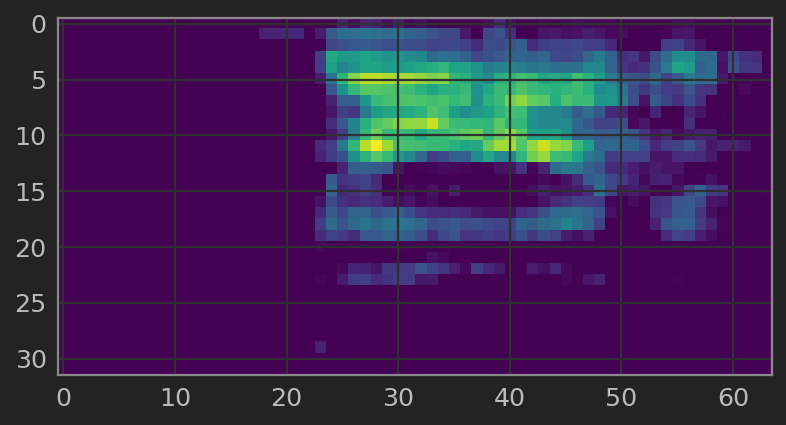

In [109]:
if __name__ == '__main__':
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'
    from jupyterthemes import jtplot
    jtplot.style()
    
    import IPython.display as ipd
    
    f = '/d2/caches/tf-speech/train/audio/dog/00b01445_nohash_0.wav'
    dg = DataGenerator('/d2/caches/tf-speech/train/audio')
    dg.n_mels = 32
    dg.msg_w = 64
    m = dg.msg(wavfile.read(f)[1])
    plt.imshow(m)

In [111]:
if __name__ == '__main__':
    
    f = (dg.input_files)
    print(f)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [112]:
f

{'/d2/caches/tf-speech/train/audio/yes/023a61ad_nohash_2.wav': 'yes',
 '/d2/caches/tf-speech/train/audio/sheila/3006c271_nohash_0.wav': 'sheila',
 '/d2/caches/tf-speech/train/audio/two/b19f7f5f_nohash_1.wav': 'two',
 '/d2/caches/tf-speech/train/audio/right/37b03ab1_nohash_1.wav': 'right',
 '/d2/caches/tf-speech/train/audio/stop/bab36420_nohash_4.wav': 'stop',
 '/d2/caches/tf-speech/train/audio/three/c08585c1_nohash_0.wav': 'three',
 '/d2/caches/tf-speech/train/audio/six/ec201020_nohash_0.wav': 'six',
 '/d2/caches/tf-speech/train/audio/bird/aba19127_nohash_0.wav': 'bird',
 '/d2/caches/tf-speech/train/audio/off/d94eb94f_nohash_1.wav': 'off',
 '/d2/caches/tf-speech/train/audio/on/efa16ffd_nohash_2.wav': 'on',
 '/d2/caches/tf-speech/train/audio/three/888a0c49_nohash_0.wav': 'three',
 '/d2/caches/tf-speech/train/audio/dog/c08585c1_nohash_1.wav': 'dog',
 '/d2/caches/tf-speech/train/audio/three/8c7c9168_nohash_1.wav': 'three',
 '/d2/caches/tf-speech/train/audio/up/c1d39ce8_nohash_4.wav': 'up'

In [105]:
print(re.findall('audio/([^/]+)/', f[0]))

['three']


In [106]:
print(re.findall('audio/([^/]+)/', '/d2/caches/tf-speech/test/audio/968768_sss.vaw'))

[]
